In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set up paths

prototype_dir = os.getcwd()
print(prototype_dir)

parent = os.path.dirname(prototype_dir)
parent_dir = os.path.dirname(parent)
sys.path.append(parent_dir)
print(parent_dir)

top_dir = os.path.dirname(parent_dir)
print(top_dir)

data_dir = top_dir + r'\neuroscikit_test_data\sequential_axona_sessions'
print(data_dir)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\_prototypes\wave_form_sorter
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\sequential_axona_sessions


In [7]:
# Set up imports from neuroscikit

from core.spikes_and_waves import (
    SpikeTrain,
    SpikeTrainBatch,
    Spike,
    SpikeCluster,
    SpikeClusterBatch,
)

from x_io.rw.axona.read_tetrode_and_cut import (
    load_spike_train_from_paths,
    _read_cut,
    _format_spikes
)

from core.subject import (
    Animal
)

from x_io.study import (
    Study,
    make_seconds_index_from_rate
)


In [8]:
# Test data we are using has two sets of sequential sessions --> extract

files = os.listdir(data_dir)

test1_34 = []
test1_35 = []
test2_34 = []
test2_35 = []

for f in files:
    if 'Test1' in f and '34' in f:
        test1_34.append(f)
    elif 'Test1' in f and '35' in f:
        test1_35.append(f)
    elif 'Test2' in f and '34' in f:
        test2_34.append(f)
    elif 'Test2' in f and '35' in f:
        test2_35.append(f)

In [9]:
# Get tet and cut files from inside folders

# session1 = test1_34
# session2 = test2_34

session1 = test1_35
session2 = test2_35

assert len(session1) == len(session2)

session1_tets = []
session2_tets = []

for i in range(len(session1)):
    if 'cut' in session1[i]:
        session1_cut = session1[i]
    if 'cut' in session2[i]:
        session2_cut = session2[i]
    file_session_1 = session1[i]
    file_session_2 = session2[i]
    out1 = file_session_1.split('.')[-1]
    out2 = file_session_2.split('.')[-1]
    if out1.isnumeric() and 'clu' not in file_session_1:
        session1_tets.append(session1[i])
    if out2.isnumeric() and 'clu' not in file_session_2:
        session2_tets.append(session2[i])

session1_cut_path = os.path.join(data_dir, session1_cut)
session1_tet_path = os.path.join(data_dir, session1_tets[0])

session2_cut_path = os.path.join(data_dir, session2_cut)
session2_tet_path = os.path.join(data_dir, session2_tets[0])

In [6]:
# NOTES
# 
# add duration
# go overwhich classes use self.timestamp
# make Neuron instead of SpikeCluster. Neuron class more extensible, for now merge SpikeTrain fxns, later will want to ahve 
# summary fxns to see easily if waveform data available or not, maybe make it optional to pass in 
# check combination of inputs, e.g. if waveforms, need timestamps
# e.g. waveforms put in dictionary that holds diff. attributes/stats that can be added to by user --> fxn
# also will ahve to add fxn to check that user can add data to the dict

# look into error raising that doesnt stop code if exists

# spike object --> neuron --> ensemble --> study
# ensemble most complex, holds covariates
# study ensures conssitency across ensembles, e.g. if one ensemble has this attribute then so do other ensembles
# extensible and flexible
# study class has functions to return e.g. sorted ensembles/neurons based on added covariate/added attribute

# inside file loading classes, make spike objects add to ensemble and in batch_load add ensembles to study

# NEw plan: Animal --> Contexts (sess  ions) --> SpikeTrain --> Spike object (event)
# Ensemble --> neuron --> spike object

# new new plan
# Study --> Animal --> Events
# Neuron is attribute of event (e.g. spike belonging to a neuron)
# polymorphism of events would be spikes (also e.g. lfp)
# Ensembles (data structure resulting from group by e.g. spatial, context, maze), can span animal ,session, study


In [10]:
# read data from cut and tet files

with open(session1_cut_path, 'r') as cut_file1, open(session1_tet_path, 'rb') as tetrode_file1:
    cut_data1 = _read_cut(cut_file1)
    tetrode_data1 = _format_spikes(tetrode_file1)
    # ts, ch1, ch2, ch3, ch4, spikeparam

with open(session2_cut_path, 'r') as cut_file2, open(session2_tet_path, 'rb') as tetrode_file2:
    cut_data2 = _read_cut(cut_file2)
    tetrode_data2 = _format_spikes(tetrode_file2)
    # ts, ch1, ch2, ch3, ch4, spikeparam

In [11]:
# Make dictionaries for core classes

sample_length1 =  tetrode_data1[-1]['duration']
sample_rate1 = tetrode_data1[-1]['samples_per_spike']

session_dict1 = {
    'spike_times': tetrode_data1[0].squeeze().tolist(),
    'cluster_labels': cut_data1,
    'ch1': tetrode_data1[1],
    'ch2': tetrode_data1[2],
    'ch3': tetrode_data1[3],
    'ch4': tetrode_data1[4],
}

sample_length2 =  tetrode_data2[-1]['duration']
sample_rate2 = tetrode_data2[-1]['samples_per_spike']

session_dict2 = {
    'spike_times': tetrode_data2[0].squeeze().tolist(),
    'cluster_labels': cut_data2,
    'ch1': tetrode_data2[1],
    'ch2': tetrode_data2[2],
    'ch3': tetrode_data2[3],
    'ch4': tetrode_data2[4],
}

assert sample_length1 == sample_length2
assert sample_rate1 == sample_rate2

study_dict = {
    'sample_length': sample_length1,
    'sample_rate': sample_rate1,
    'animal_ids': []
}

animal_dict = {
    'id': '0',
}

animal_dict[0] = session_dict1
animal_dict[1] = session_dict2

In [9]:
# Make study + add animal with sessions, can also add sessions one at a time after making animal instance

study = Study(study_dict)

study.add_animal(animal_dict)

animal = study.animals[0]

In [10]:
def sort_cell_spike_times(spike_times, cluster_labels, waveforms):
    """
    Takes multiple sessions with spike times, cluster_labels and waveforms.

    Returns valid cells for each session and associated waveforms
    """

    assert len(spike_times) == len(cluster_labels)

    cells = [[] for i in range(len(spike_times))]
    sorted_waveforms = [[] for i in range(len(spike_times))]
    good_cells = [[] for i in range(len(spike_times))]
    good_sorted_waveforms = [[] for i in range(len(spike_times))]

    for i in range(len(spike_times)):
        labels = np.unique(cluster_labels[i])
        # comes in shape (channel count, spike time, nmb samples) but is nested list not numpy
        # want to rearrannge to be (spike time, channel count, nmb sample )
        waves = np.array(waveforms[i]).reshape((len(waveforms[i][0]), len(waveforms[i]),  len(waveforms[i][0][0])))
        for lbl in labels:
            idx = np.where(cluster_labels[i] == lbl)
            cells[i].append(np.array(spike_times[i])[idx])
            sorted_waveforms[i].append(waves[idx,:,:].squeeze())

        empty_cell = 1
        for j in range(len(sorted_waveforms[i])):
            if len(sorted_waveforms[i][j]) == 0 and j != 0:
                empty_cell = j
                break
            else:
                empty_cell = j + 1
        for j in range(1,empty_cell,1):
            good_cells[i].append(cells[i][j])
            good_sorted_waveforms[i].append(sorted_waveforms[i][j])
    
    return good_cells, good_sorted_waveforms


In [11]:
def waveform_template(waveforms):
    """
    Averages cell waveforms for each session
    """
    averaged_waveforms = [[] for i in range(len(waveforms))]
    # for each session
    for i in range(len(waveforms)):
        # for each cell
        for j in range(len(waveforms[i])):
            avg = np.mean(waveforms[i][j].squeeze(), axis=0)
            averaged_waveforms[i].append(avg)
    return averaged_waveforms

In [12]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):
    __author__ = "Marcos Duarte, https://github.com/demotu/BMC"
    __version__ = "1.0.4"
    __license__ = "MIT"

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`

    The function can handle NaN's

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan - 1, indnan + 1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind] - x[ind - 1], x[ind] - x[ind + 1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                              & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        # _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


In [13]:
def get_peak_amplitudes(waveforms):
    """
    Get peak amplitudes and ids of peaks
    """
    peaks = [[] for i in range(len(waveforms))]
    peak_ids = [[] for i in range(len(waveforms))]
    for i in range(len(waveforms)):
        for j in range(len(waveforms[i])):
            cell_peak = []
            cell_peak_id = []
            for k in range(len(waveforms[i][j])):
                cell_peak.append(np.max(waveforms[i][j][k]))
                cell_peak_id.append(np.argmax(waveforms[i][j][k]))
            peaks[i].append(cell_peak)
            peak_ids[i].append(cell_peak_id)
    return peaks, peak_ids

In [14]:
def get_spike_statistics(cell_waveforms, sample_rate):
    """
    Get spike width data for one cell

    input shape is (num spikes, num channel, num samples per waveform)
    """
    avg_waveform = np.mean(cell_waveforms, axis=0)

    pp_amp = np.zeros((cell_waveforms.shape[0], cell_waveforms.shape[1]))
    pt_width = np.zeros_like(pp_amp)
    peak_cell = np.zeros_like(pp_amp)
    # aup = np.zeros_like(pp_amp)

    reshaped_waveforms = np.zeros((cell_waveforms.shape[1], cell_waveforms.shape[0], cell_waveforms.shape[2]))
    for i in range(len(cell_waveforms)):
        for j in range(len(cell_waveforms[i])):
            reshaped_waveforms[j,i] = cell_waveforms[i,j]
    cell_waveforms = reshaped_waveforms

    for chan_index, channel in enumerate(cell_waveforms):

        for spike_index, spike in enumerate(channel):
            # aup[spike_index, chan_index] = AUP(spike, t_peak)

            t = ((10 ** 6) / sample_rate) * np.arange(0, len(spike))

            locs = detect_peaks(spike, edge='both', threshold=0)

            pks = spike[locs]

            if len(pks) == 0:
                peak_cell[spike_index, :] = np.NaN

            else:
                max_ind = np.where(pks == np.amax(pks))[0]  # finding the index of the max value
                locs_ts = locs * (10 ** 6. / sample_rate)  # converting the peak locations to seconds
                min_val = np.amin(spike[np.where(t > locs_ts[max_ind[0]])[0]])  # finding the minimum value
                min_ind = np.where((spike == min_val) & (t > locs_ts[max_ind[0]]))[0][
                    0]  # finding the index of the minimum value
                min_t = t[min_ind]  # converting the index to a time value
                peak_cell[spike_index, :] = np.array([np.amax(pks), locs_ts[max_ind[0]], min_val, min_t])

            # if sum(np.isnan(peak_cell[:, 0])) != 0:
            #     print('waveform with no peaks')
            #     print(chan_index, locs)
            #     print(spike_index, spike)
            #     print(channel[spike_index])
            #     sto()

            pp_amp[:, chan_index] = peak_cell[:, 0] - peak_cell[:, 2]
            pt_width[:, chan_index] = peak_cell[:, 1] - peak_cell[:, 3]

            # ------------ Done calculating the peak to peaks and peak to through values ------------- #

        avg_pp_amp = np.zeros((1, len(cell_waveforms)))
        avg_pt_width = np.zeros_like(avg_pp_amp)
        # avg_aup = np.zeros_like(avg_pp_amp)

        for waveform_index, waveform in enumerate(avg_waveform):
            locs = detect_peaks(waveform, edge='both', threshold=0)
            locs_ts = locs * (10 ** 6. / sample_rate)  # converting the peak locations to seconds
            pks = waveform[locs]
            max_val = np.amax(pks)
            max_ind = np.where(pks == max_val)[0]  # finding the index of the max value
            max_t = locs_ts[max_ind[0]]
            min_val = np.amin(waveform[np.where(t > locs_ts[max_ind[0]])[0]])  # finding the minimum value
            min_ind = np.where(waveform == min_val)[0]  # finding the index of the minimum value
            min_t = t[min_ind]  # converting the index to a time value
            avg_pp_amp[0, waveform_index] = max_val - min_val
            avg_pt_width[0, waveform_index] = min_t - max_t
            # avg_aup[0, waveform_index] = AUP(waveform, t_peak)
    # ------------ ended avg_waveform calculations ------------------- #
    best_channel = np.where(avg_pp_amp == np.amax(avg_pp_amp))[1][0]

    channel = 'ch%d' % int(best_channel + 1)
    waveform_dict = {}
    for channel_index, channel_waveform in enumerate(cell_waveforms):
        waveform_dict['ch%d' % int(channel_index + 1)] = channel_waveform
    waveform_dict.update({'sample_rate': sample_rate, 'pp_amp': avg_pp_amp[0],
                          'spike_width': avg_pt_width[0], 'peak_channel': best_channel})
    return waveform_dict

In [15]:
def sort_waveforms_by_sesssion(animal: Animal):
    """
    Sort waveforms by session
    """
    cells, sorted_waveforms = sort_cell_spike_times(animal.agg_spike_times, animal.agg_cluster_labels, animal.agg_waveforms)

    waveforms = waveform_template(sorted_waveforms)

    peaks, peak_ids = get_peak_amplitudes(waveforms)

    agg_waveform_dict = {}
    for i in range(len(sorted_waveforms)):
        session_key = 'session_' + str(i+1)
        agg_waveform_dict[session_key] = {}
        for j in range(len(sorted_waveforms[i])):
            waveform_dict = get_spike_statistics(sorted_waveforms[i][j], study.sample_rate)
            orders = get_possible_orders(waveform_dict['pp_amp'], threshold=0.2)
            waveform_dict['channel_orders'] = orders
            cell_key = 'cell_' + str(j+1)
            agg_waveform_dict[session_key][cell_key] = waveform_dict

In [16]:
def make_vectors(spike_amps, spike_widths, peak_channels):
    """
    Vectors will be in format [[start x, start y], [end x, end y]]
    """

    vectors = [[] for i in range(len(spike_amps))]

    tet_x_coord = [-1,1,1,-1]
    tet_y_coord = [1,1,-1,-1]

    for i in range(len(spike_amps)):
        ses_amps = spike_amps[i]
        mn = np.mean(ses_amps)
        std = np.std(ses_amps)
        for j in range(len(ses_amps)):
            cell_amps = (ses_amps[j] - mn)/std
            cell_widths = spike_widths[i][j]
            cell_peak = peak_channels[i][j]

            loc_x = np.sum(np.array(tet_x_coord) * np.array(cell_amps))
            loc_y = np.sum(np.array(tet_y_coord) * np.array(cell_amps))

            vector = [loc_x, loc_y, tet_x_coord[cell_peak], tet_y_coord[cell_peak]]
            # vector = [0, 0, loc_x, loc_y]
            vectors[i].append(vector)
            
    return vectors


In [17]:
def get_switch_channels(pp_amp, threshold):
    """
    For session for cell, get channel in tetrode that could switch in a possible ordering
    """
    can_switch = []
    for i in range(len(pp_amp)):
        for j in range(len(pp_amp)):
            pair = np.sort([i,j]).tolist()
            if i != j and pair not in can_switch:
                diff = abs(pp_amp[i] - pp_amp[j])
                if diff <= threshold:
                    can_switch.append(pair)
    return can_switch

In [24]:
def get_possible_orders(pp_amp, threshold=.2):
    """ 
    Get possible ordering for a cell
    """
    # avg_waveform = np.mean(cell_waveforms, axis=0)
    possible_orders = []

    can_switch = get_switch_channels(pp_amp, threshold)
    switched = []
    true_order = np.argsort(pp_amp)
    possible_orders.append(true_order.tolist())
    
    for i in range(len(pp_amp)):
        for j in range(len(can_switch)):
            if i in can_switch[j] and can_switch[j] not in switched:
                new_order = np.copy(true_order)
                id1 = np.where(new_order == can_switch[j][0])[0]
                id2 = np.where(new_order == can_switch[j][1])[0]
                new_order[id1] = can_switch[j][1]
                new_order[id2] = can_switch[j][0]
                switched.append(can_switch[j])
                possible_orders.append(new_order.tolist())

    return possible_orders

In [25]:

cells, sorted_waveforms = sort_cell_spike_times(animal.agg_spike_times, animal.agg_cluster_labels, animal.agg_waveforms)

waveforms = waveform_template(sorted_waveforms)
peaks, peak_ids = get_peak_amplitudes(waveforms)

agg_waveform_dict = {}
for i in range(len(sorted_waveforms)):
    session_key = 'session_' + str(i+1)
    agg_waveform_dict[session_key] = {}
    for j in range(len(sorted_waveforms[i])):
        waveform_dict = get_spike_statistics(sorted_waveforms[i][j], study.sample_rate)
        orders = get_possible_orders(waveform_dict['pp_amp'], threshold=0.2)
        waveform_dict['channel_orders'] = orders
        cell_key = 'cell_' + str(j+1)
        agg_waveform_dict[session_key][cell_key] = waveform_dict


In [26]:
# Check if possible orders for each cell match across sessions

session_1 = agg_waveform_dict['session_1']
session_2 = agg_waveform_dict['session_2']

matched = []

for i in session_1:
    for j in session_2:
        cell_1 = session_1[i]['channel_orders']
        cell_2 = session_2[j]['channel_orders']
        if len(cell_1) > 0 and len(cell_2) > 0:
            if type(cell_1[0]) == list and type(cell_2[0]) == list:
                for k in range(len(cell_1)):
                    if cell_1[k] in cell_2:
                        matched.append([int(i.split('_')[-1]), int(j.split('_')[-1])])
            elif type(cell_1[0]) == list and type(cell_2[0]) != list:
                for k in range(len(cell_1)):
                    if cell_1[k] == cell_2:
                        matched.append([int(i.split('_')[-1]), int(j.split('_')[-1])])
            elif type(cell_1[0]) != list and type(cell_2[0]) == list:
                for k in range(len(cell_2)):
                    if cell_1 == cell_2[k]:
                        matched.append([int(i.split('_')[-1]), int(j.split('_')[-1])])
            elif type(cell_1[0]) != list and type(cell_2[0]) != list:
                if cell_1 == cell_2:
                    matched.append([int(i.split('_')[-1]), int(j.split('_')[-1])])

In [27]:
# fig = plt.figure(figsize=(20,20))

# dim1 = len(session_1)
# dim2 = len(session_2)

# axs = []

# session_1_pos = [1,3,5,7,9]
# # 11,13,15,17,19]
# session_2_pos = [2,4,6,8,10]
# # 12,14,16,18,20]


# for i in range(dim1):
#     ax = plt.subplot(dim1+dim2, 2, session_1_pos[i])
#     cell_dict = session_1['cell_'+str(i+1)]
#     for key in cell_dict:
#         if key.split('ch')[-1].isnumeric():
#             ax.plot(np.mean(cell_dict[key], axis=0), label=key)
#             # ax.legend()
#     axs.append(ax)
    
#     ax = plt.subplot(dim1+dim2, 2, session_2_pos[i])
#     cell_dict = session_2['cell_'+str(i+1)]
#     for key in cell_dict:
#         if key.split('ch')[-1].isnumeric():
#             ax.plot(np.mean(cell_dict[key], axis=0), label=key)
#             # ax.legend()
#     axs.append(ax)

# for ax in axs:
#     ax.set_ylabel('Waveform')
#     ax.set_xlabel('Sample')
    

# fig.tight_layout()
# plt.show()
    

In [28]:
# Aggregate spike width and amp

agg_spike_amp = [[] for i in range(len(agg_waveform_dict))]
agg_spike_width = [[] for i in range(len(agg_waveform_dict))]
agg_peak_channel = [[] for i in range(len(agg_waveform_dict))]

c = 0
for session_key in agg_waveform_dict:
    session = agg_waveform_dict[session_key]
    for cell_key in session:
        cell = session[cell_key]
        agg_spike_amp[c].append(cell['pp_amp'])
        agg_spike_width[c].append(cell['spike_width'])
        agg_peak_channel[c].append(cell['peak_channel'])
    c += 1

agg_spike_amp = np.array(agg_spike_amp)
agg_spike_width = np.array(agg_spike_width)

C:\Users\aaoun\AppData\Local\Temp\ipykernel_19012\1912502892.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  agg_spike_amp = np.array(agg_spike_amp)
C:\Users\aaoun\AppData\Local\Temp\ipykernel_19012\1912502892.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  agg_spike_width = np.array(agg_spike_width)


In [29]:
vectors = make_vectors(agg_spike_amp, agg_spike_width, agg_peak_channel)

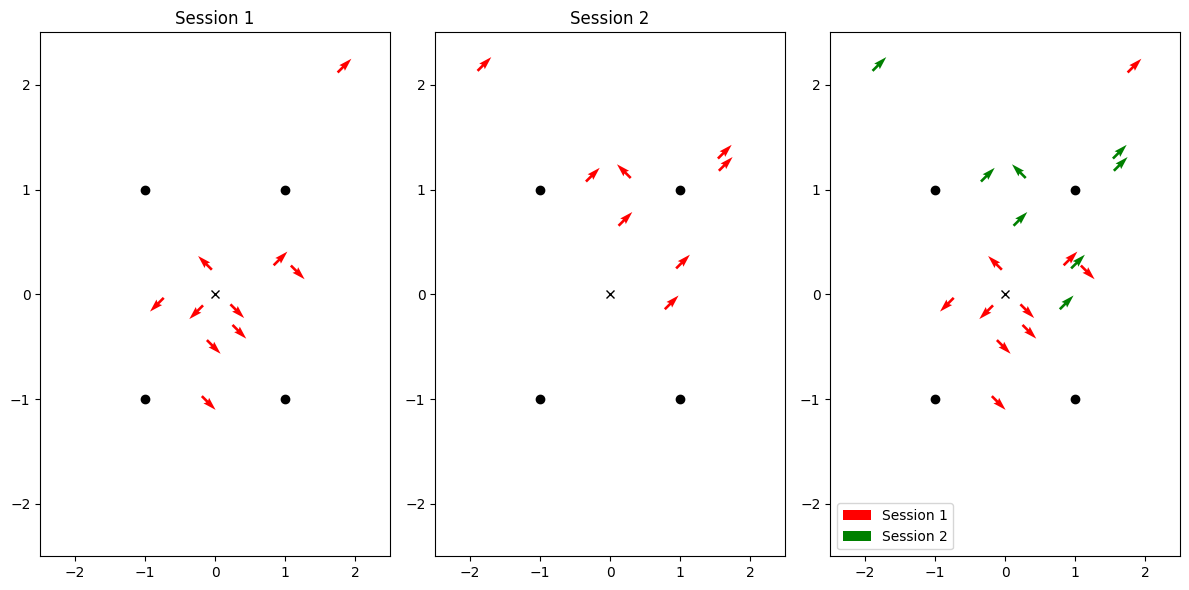

In [30]:
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
axs = [ax1, ax2, ax3]
labels = ['Session 1', 'Session 2']
colors = ['r', 'g']

for i in range(len(vectors)):
    for j in range(len(vectors[i])):
        vector = vectors[i][j]
        axs[i].quiver(vector[0], vector[1], vector[2], vector[3], color='r')

        if j == 0:
            axs[-1].quiver(vector[0], vector[1], vector[2], vector[3], color=colors[i], label=labels[i])
        else:
            axs[-1].quiver(vector[0], vector[1], vector[2], vector[3], color=colors[i])

for ax in axs:
    # center
    ax.plot(0, 0, 'kx')
    # tetrode 1
    ax.plot(-1, 1, 'ko')
    # tetrode 2
    ax.plot(1, 1, 'ko')
    # tetrode 1
    ax.plot(1, -1, 'ko')
    # tetrode 1
    ax.plot(-1, -1, 'ko')

    ax.set_ylim(-2.5,2.5)
    ax.set_xlim(-2.5,2.5)

axs[-1].legend()
axs[0].set_title(labels[0])
axs[1].set_title(labels[1])

fig.tight_layout()
plt.show()


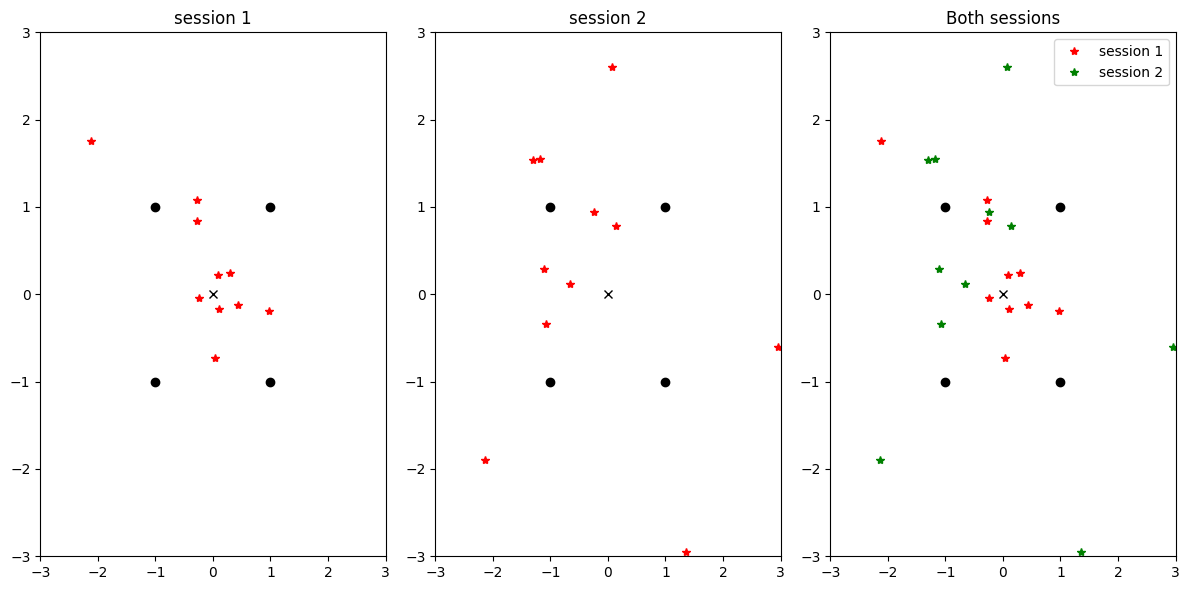

In [31]:
fig = plt.figure(figsize=(12,6))

# tet_coords = [[0,0], [-1,1], [1,1], [1,-1]]
tet_coords = [[-1,-1,1,1], [-1,1,1,-1]]

ax1 = fig.add_subplot(1,3,1)

mean_amp = np.mean(agg_spike_amp[0])
std_amp = np.std(agg_spike_amp[0])
mean_wid = np.mean(agg_spike_width[0])
std_wid = np.std(agg_spike_width[0])
for i in range(len(agg_spike_amp[0])):
    tet_amp = (agg_spike_amp[0][i] - mean_amp)/std_amp
    tet_width = (agg_spike_width[0][i] - mean_wid)/std_wid

    to_plot_x = np.array(tet_coords[0]) * np.array(tet_amp) 
    to_plot_y = np.array(tet_coords[1]) * np.array(tet_amp) 
    to_plot = [sum(to_plot_x), sum(to_plot_y)]

    ax1.plot(to_plot[0], to_plot[1], 'r*')
    # print(to_plot)
    # ax1.quiver(np.array([0,0]), to_plot)

ax1.set_title('session 1')

ax2 = fig.add_subplot(1,3,2)

mean_amp = np.mean(agg_spike_amp[1])
std_amp = np.std(agg_spike_amp[1])
mean_wid = np.mean(agg_spike_width[1])
std_wid = np.std(agg_spike_width[1])
for i in range(len(agg_spike_amp[1])):
    tet_amp = (agg_spike_amp[1][i] - mean_amp)/std_amp
    tet_width = (agg_spike_width[1][i] - mean_wid)/std_wid

    to_plot_x = np.array(tet_coords[0]) * np.array(tet_amp) 
    to_plot_y = np.array(tet_coords[1]) * np.array(tet_amp) 
    to_plot = [sum(to_plot_x), sum(to_plot_y)]

    ax2.plot(to_plot[0], to_plot[1], 'r*')

ax2.set_title('session 2')

ax3 = fig.add_subplot(1,3,3)

mean_amp = np.mean(agg_spike_amp[0])
std_amp = np.std(agg_spike_amp[0])
mean_wid = np.mean(agg_spike_width[0])
std_wid = np.std(agg_spike_width[0])
for i in range(len(agg_spike_amp[0])):
    tet_amp = (agg_spike_amp[0][i] - mean_amp)/std_amp
    tet_width = (agg_spike_width[0][i] - mean_wid)/std_wid
    
    to_plot_x = np.array(tet_coords[0]) * np.array(tet_amp) 
    to_plot_y = np.array(tet_coords[1]) * np.array(tet_amp) 
    to_plot = [sum(to_plot_x), sum(to_plot_y)]

    if i == 0:
        ax3.plot(to_plot[0], to_plot[1], 'r*', label='session 1')
    else:
        ax3.plot(to_plot[0], to_plot[1], 'r*')
    
mean_amp = np.mean(agg_spike_amp[1])
std_amp = np.std(agg_spike_amp[1])
mean_wid = np.mean(agg_spike_width[1])
std_wid = np.std(agg_spike_width[1])
for i in range(len(agg_spike_amp[1])):
    tet_amp = (agg_spike_amp[1][i] - mean_amp)/std_amp
    tet_width = (agg_spike_width[1][i] - mean_wid)/std_wid
    
    to_plot_x = np.array(tet_coords[0]) * np.array(tet_amp) 
    to_plot_y = np.array(tet_coords[1]) * np.array(tet_amp) 
    to_plot = [sum(to_plot_x), sum(to_plot_y)]

    if i == 0:
        ax3.plot(to_plot[0], to_plot[1], 'g*', label='session 2')
    else:
        ax3.plot(to_plot[0], to_plot[1], 'g*')

ax3.set_title('Both sessions')
ax3.legend()

axs = [ax1, ax2, ax3]

for ax in axs:
    # center
    ax.plot(0, 0, 'kx')
    # tetrode 1
    ax.plot(-1, 1, 'ko')
    # tetrode 2
    ax.plot(1, 1, 'ko')
    # tetrode 1
    ax.plot(1, -1, 'ko')
    # tetrode 1
    ax.plot(-1, -1, 'ko')

    ax.set_ylim(-3,3)
    ax.set_xlim(-3,3)

fig.tight_layout()
plt.show()



In [34]:
matched

[[3, 4], [3, 13], [4, 1], [5, 12], [6, 7], [10, 12]]

In [1]:

def _find_consec(data):
    '''finds the consecutive numbers and outputs as a list'''
    consecutive_values = []  # a list for the output
    current_consecutive = [data[0]]

    if len(data) == 1:
        return [[data[0]]]

    for index in range(1, len(data)):

        if data[index] == data[index - 1] + 1:
            current_consecutive.append(data[index])

            if index == len(data) - 1:
                consecutive_values.append(current_consecutive)

        else:
            consecutive_values.append(current_consecutive)
            current_consecutive = [data[index]]

            if index == len(data) - 1:
                consecutive_values.append(current_consecutive)
    return consecutive_values

In [8]:
import numpy as np
a = np.random.shuffle(np.arange(0,10,.1))

AttributeError: module 'numpy' has no attribute 'shuffle'

In [32]:
# peaks = [[] for i in range(len(waveforms))]
# for i in range(len(waveforms)):
#     for j in range(len(waveforms[i])):
#         cell_peak = []
#         for k in range(len(waveforms[i][j])):
#             cell_peak.append(np.argmax(waveforms[i][j][k]))
#         peaks[i].append(cell_peak)

In [33]:
from __future__ import division, print_function
import numpy as np
import struct, os
import numpy.matlib
from scipy.io import savemat
import mmap
import contextlib


def int16toint8(value):
    """Converts int16 data to int8"""
    value = np.divide(value, 256).astype(int)
    value[np.where(value > 127)] = 127
    value[np.where(value < -128)] = -128

    return value


def remEEGShift(t, EEG):
    """This function removes the shift that the EEG undergoes"""
    EEG = EEG.flatten()
    Fs_EGF = int(4.8e3)
    # normal delay is 0.5(n_taps-1) / Fs_EGF, n_taps is 101 for the FIR filter
    # there is already a shift of 18 as the EEG starts off using the 18th EGF data
    delay = (0.5 * (101 - 1) - 18) / Fs_EGF

    t = t - delay

    t_bool = np.where(t >= 0)[0]
    t = t[t_bool]
    EEG = EEG[t_bool]

    return t, EEG


def MatlabNumSeq(start, stop, step, exclude=True):
    """In Matlab you can type:

    start:step:stop and easily create a numerical sequence

    if exclude is true it will exclude any values greater than the stop value
    """

    '''np.arange(start, stop, step) works good most of the time

    However, if the step (stop-start)/step is an integer, then the sequence
    will stop early'''

    seq = np.arange(start, stop + step, step)

    if exclude:
        if seq[-1] > stop:
            seq = seq[:-1]

    return seq


class TintException(Exception):
    def __init___(self, message):
        Exception.__init__(self, "%s" % message)
        self.message = message


def get_good_cells(units):
    """
    In Tint we have a method of determining the 'good cells'. A good tetrode must begin
    with cell #1, and the set of consecutive cell numberes are all good. Essentially we leave
    a blank cell separating the good cells from the bad. This function will return the good cells.
    """
    units = np.unique(units)

    if 1 not in units:
        return np.array([])

    good_cells = [1]

    found_separation = False
    for index, unit in enumerate(units):
        if unit > 1:
            if unit == units[index - 1] + 1 and not found_separation:
                good_cells.append(unit)
            else:  #
                # no longer consecutive units, so set value to false to ensure no more appending
                found_separation = True

    return np.asarray(good_cells)


def get_setfile_parameter(parameter, set_filename):
    """
    This function will return the parameter value of a given parameter name for a given set filename.

    Example:
        set_fullpath = 'C:\\example\\tetrode_1.1'
        parameter_name = 'duration
        duration = get_setfile_parameter(parameter_name, set_fullpath)

    Args:
        parameter (str): the name of the set file parameter that you want to obtain.
        set_filename (str): the full path of the .set file that you want to obtain the parameter value from.


    Returns:
        parameter_value (str): the value for the given parameter

    """

    if not os.path.exists(set_filename):
        return

    # adding the encoding because tint data is created via windows and if you want to run this in linux, you need
    # to explicitly say this
    with open(set_filename, 'r+', encoding='cp1252') as f:
        for line in f:
            if parameter in line:
                if line.split(' ')[0] == parameter:
                    # prevents part of the parameter being in another parameter name
                    new_line = line.strip().split(' ')
                    if len(new_line) == 2:
                        return new_line[-1]
                    else:
                        return ' '.join(new_line[1:])


def getpos(position_filename, ppm=None, center=None, method=None, flip_y=True):
    """
    This method will allow you to provide a position filename and a few parameters to obtain the position values.

    :param position_filename: filename value to your .pos file: 'c:\\example_session.pos'
    :param ppm: pixels per meter value to convert the data that is stored in bits, to a meter (or centimeter) value.
    :param center: the center point of the arena [center_x, center_y]
    :param method: I allow a method function so that I can return the raw values if I want. To receive the values as
        the data was saved, use method='raw'.
    :param flip_y: this will flip the y values as is done in Tint
    :return: x, y, t, Fs
    """
    num_pos_samples = None
    x = None
    y = None
    t = None
    Fs = None
    timebase = None
    two_spot = True
    with open(position_filename, 'rb+') as f:  # opening the .pos file
        headers = ''  # initializing the header string
        for line in f:  # reads line by line to read the header of the file
            # print(line)
            if 'data_start' in str(line):  # if it reads data_start that means the header has ended
                headers += 'data_start'
                break  # break out of for loop once header has finished
            elif 'duration' in str(line):
                headers += line.decode(encoding='UTF-8')
            elif 'num_pos_samples' in str(line):
                num_pos_samples = int(line.decode(encoding='UTF-8')[len('num_pos_samples '):])
                headers += line.decode(encoding='UTF-8')
            elif 'bytes_per_timestamp' in str(line):
                # bytes_per_timestamp = int(line.decode(encoding='UTF-8')[len('bytes_per_timestamp '):])
                headers += line.decode(encoding='UTF-8')
            elif 'bytes_per_coord' in str(line):
                # bytes_per_coord = int(line.decode(encoding='UTF-8')[len('bytes_per_coord '):])
                headers += line.decode(encoding='UTF-8')
            elif 'timebase' in str(line):
                timebase = (line.decode(encoding='UTF-8')[len('timebase '):]).split(' ')[0]
                headers += line.decode(encoding='UTF-8')
            elif 'pixels_per_metre' in str(line):
                if ppm is None:
                    ppm = float(line.decode(encoding='UTF-8')[len('pixels_per_metre '):])
                headers += line.decode(encoding='UTF-8')
            elif 'min_x' in str(line) and 'window' not in str(line):
                # min_x = int(line.decode(encoding='UTF-8')[len('min_x '):])
                headers += line.decode(encoding='UTF-8')
            elif 'max_x' in str(line) and 'window' not in str(line):
                # max_x = int(line.decode(encoding='UTF-8')[len('max_x '):])
                headers += line.decode(encoding='UTF-8')
            elif 'min_y' in str(line) and 'window' not in str(line):
                # min_y = int(line.decode(encoding='UTF-8')[len('min_y '):])
                headers += line.decode(encoding='UTF-8')
            elif 'max_y' in str(line) and 'window' not in str(line):
                # max_y = int(line.decode(encoding='UTF-8')[len('max_y '):])
                headers += line.decode(encoding='UTF-8')
            elif 'pos_format' in str(line):
                headers += line.decode(encoding='UTF-8')
                if 't,x1,y1,x2,y2,numpix1,numpix2' in str(line):
                    two_spot = True
                else:
                    two_spot = False
                    print('The position format is unrecognized!')

            elif 'sample_rate' in str(line):
                Fs = float(line.decode(encoding='UTF-8').split(' ')[1])
                headers += line.decode(encoding='UTF-8')

            else:
                headers += line.decode(encoding='UTF-8')

    # currently we only really use the two_spot mode from Tint, so that is all that is coded
    if two_spot:
        '''Run when two spot mode is on, (one_spot has the same format so it will also run here)'''
        with open(position_filename, 'rb+') as f:
            '''get_pos for one_spot'''
            pos_data = f.read()  # all the position data values (including header)
            pos_data = pos_data[len(headers):-12]  # removes the header values

            byte_string = 'i8h'

            pos_data = np.asarray(struct.unpack('>%s' % (num_pos_samples * byte_string), pos_data))
            pos_data = pos_data.astype(float).reshape((num_pos_samples, 9))  # there are 8 words and 1 time sample

        x = pos_data[:, 1]
        y = pos_data[:, 2]
        t = pos_data[:, 0]

        x = x.reshape((len(x), 1))
        y = y.reshape((len(y), 1))
        t = t.reshape((len(t), 1))

        if method is not None:
            if method == 'raw':
                return x, y, t, Fs
            else:
                pass

        t = np.divide(t, np.float(timebase))  # converting the frame number from Axona to the time value

        # values that are NaN are set to 1023 in Axona's system, replace these values by NaN's

        x[np.where(x == 1023)] = np.nan
        y[np.where(y == 1023)] = np.nan

        didFix, fixedPost = fixTimestamps(t)

        if didFix:
            t = fixedPost

        t = t - t[0]

        # if there was some timestamp fixing, then the length of the time array could be less than that of the x and y
        # check that here and correct lengths
        if len(t) != len(x):
            x = x[:len(t)]
            y = y[:len(t)]

        # convert the data to cm
        x, y = arena_config(x, y, ppm, center=center, flip_y=flip_y)

        # remove any NaNs at the end of the file
        x, y, t = removeNan(x, y, t)

    else:
        print("Haven't made any code for this part yet.")

    return x.reshape((len(x), 1)), y.reshape((len(y), 1)), t.reshape((len(t), 1)), Fs


def is_tetrode(file, session):
    """"
    Determines if the file is a tetrode, essentially will look at the extension and see if it ends in an integer
    or not. Also checks that the tetrode belongs to a given session.
    """
    if os.path.splitext(file)[0] == session:
        try:
            tetrode_number = int(os.path.splitext(file)[1][1:])
            return True
        except ValueError:
            return False
    else:
        return False


def get_active_tetrode(set_filename):
    """in the .set files it will say collectMask_X Y for each tetrode number to tell you if
    it is active or not. T1 = ch1-ch4, T2 = ch5-ch8, etc."""
    active_tetrode = []
    active_tetrode_str = 'collectMask_'

    with open(set_filename) as f:
        for line in f:

            # collectMask_X Y, where x is the tetrode number, and Y is eitehr on or off (1 or 0)
            if active_tetrode_str in line:
                tetrode_str, tetrode_status = line.split(' ')
                if int(tetrode_status) == 1:
                    # then the tetrode is saved
                    tetrode_str.find('_')
                    tet_number = int(tetrode_str[tetrode_str.find('_') + 1:])
                    active_tetrode.append(tet_number)

    return active_tetrode


def get_active_eeg(set_filename):
    """This will return a dictionary (cative_eeg_dict) where the keys
    will be eeg channels from 1->64 which will represent the eeg suffixes (2 = .eeg2, 3 = 2.eeg3, etc)
    and the key will be the channel that the EEG maps to (a channel from 0->63)"""
    active_eeg = []
    active_eeg_str = 'saveEEG_ch'

    eeg_map = []
    eeg_map_str = 'EEG_ch_'

    active_eeg_dict = {}

    with open(set_filename) as f:
        for line in f:

            if active_eeg_str in line:
                # saveEEG_ch_X Y, where x is the eeg number, and Y is eitehr on or off (1 or 0)
                _, status = line.split(' ')
                active_eeg.append(int(status))
            elif eeg_map_str in line:
                # EEG_ch_X Y
                _, chan = line.split(' ')
                eeg_map.append(int(chan))

                # active_eeg = np.asarray(active_eeg)
                # eeg_map = np.asarray(eeg_map)

    for i, status in enumerate(active_eeg):
        if status == 1:
            active_eeg_dict[i + 1] = eeg_map[i] - 1

    return active_eeg_dict


def is_egf_active(set_filename):
    active_egf_str = 'saveEGF'

    with open(set_filename) as f:
        for line in f:

            if active_egf_str in line:
                _, egf_status = line.split(' ')

                if int(egf_status) == 1:
                    return True

        return False


def find_tetrodes(set_fullpath):
    """finds the tetrode files available for a given .set file if there is a  .cut file existing"""

    tetrode_path, session = os.path.split(set_fullpath)
    session, _ = os.path.splitext(session)

    # getting all the files in that directory
    file_list = os.listdir(tetrode_path)

    # acquiring only a list of tetrodes that belong to that set file
    tetrode_list = [os.path.join(tetrode_path, file) for file in file_list
                    if is_tetrode(file, session)]

    # if the .cut file doesn't exist remove list

    tetrode_list = [file for file in tetrode_list if os.path.exists(
        os.path.join(tetrode_path, '%s_%s.cut' % (os.path.splitext(file)[0], os.path.splitext(file)[1][1:])))]

    return tetrode_list


def find_unit(tetrode_list):
    """Inputs:
    tetrode_list: list of tetrodes to find the units that are in the tetrode_path
    example [r'C:Location\of\File\filename.1', r'C:Location\of\File\filename.2' ],
    -------------------------------------------------------------
    Outputs:
    cut_list: an nx1 list for n-tetrodes in the tetrode_list containing a list of unit numbers that each spike belongs to
    """

    input_list = True
    if type(tetrode_list) != list:
        input_list = False
        tetrode_list = [tetrode_list]

    cut_list = []
    unique_cell_list = []
    for tetrode_file in tetrode_list:
        directory = os.path.dirname(tetrode_file)

        try:
            tetrode = int(os.path.splitext(tetrode_file)[1][1:])
        except ValueError:
            raise ValueError("The following file is invalid: %s" % tetrode_file)

        tetrode_base = os.path.splitext(os.path.basename(tetrode_file))[0]

        cut_filename = os.path.join(directory, '%s_%d.cut' % (tetrode_base, tetrode))

        cut_values = read_cut(cut_filename)
        cut_list.append(cut_values)
        unique_cell_list.append(np.unique(cut_values))

    return cut_list


def read_clu(filename):
    """
    This will read in the .clu.N files that are provided by Tint. The .clu cell ID's go from 1 -> N
    instead of the traditional 0->N-1 for a .cut file. We will convert from the 1->N format to the
    0->N-1 format.
    """

    data = np.loadtxt(filename)

    # the first number in the file is simply the number of cells that were recorded, we must remove this

    # we will also subtract 1 to ensure that the data goes from 0->N-1 instead of 1->N. Essentially converting
    # from the clu format to the .cut format.

    return data[1:].flatten() - 1


def read_cut(cut_filename):
    """This function will read the given cut file, and output the """
    cut_values = None
    if os.path.exists(cut_filename):
        extract_cut = False
        with open(cut_filename, 'r') as f:
            for line in f:
                if 'Exact_cut' in line:  # finding the beginning of the cut values
                    extract_cut = True
                if extract_cut:  # read all the cut values
                    cut_values = str(f.readlines())
                    for string_val in ['\\n', ',', "'", '[', ']']:  # removing non base10 integer values
                        cut_values = cut_values.replace(string_val, '')
                    cut_values = [int(val) for val in cut_values.split()]
        cut_values = np.asarray(cut_values)
    return cut_values


def getArenaParams(arena, conversion='', center=''):
    """
    This is a legacy function back when we used to use the room name. Now I think it is best to just have the user
    provide a center and pixel-per-meter value

    :param arena:
    :param conversion:
    :param center:
    :return:
    """
    if 'BehaviorRoom' in arena:
        center = np.array([314.75, 390.5])
        conversion = 495.5234
    elif 'BehaviorRoom2' in arena:
        # added december 12th, 2018
        center = np.array([314.75, 390.5])
        conversion = 485.1185
    elif 'DarkRoom' in arena:
        center = np.array([346.5, 273.5])
        conversion = 711.3701
    elif 'room4' in arena:
        center = np.array([418, 186])
        conversion = 313
    elif arena in ['Linear Track', 'Circular Track', 'Four Leaf Clover Track', 'Simple Circular Track',
                   'Parallel Linear Global Track', 'Parallel Linear Rate Track']:
        center = center
        conversion = conversion
    else:
        print("Room: " + arena + ", is an unknown room!")

    return center, conversion


def arena_config(posx, posy, ppm, center=None, flip_y=True):
    """
    This function will convert the position values from the units of bits to centimeters. It will also center the arena
    around the point (0,0) if you provide a center value. I have added a flip_y keyword argument because the Tint
    program flips the y values so I will allow you to flip the values as well (or not).

    :param posx:
    :param posy:
    :param arena:
    :param conversion:
    :param center:
    :param flip_y: bool value that will determine if you want to flip y or not. When recording on Intan we inverted the
    positions due to the camera position. However in the virtualmaze you might not want to flip y values.
    :return:
    """

    if center is not None:
        posx = 100 * (posx - center[0]) / ppm
    else:
        posx = 100 * (posx) / ppm

    if flip_y:
        # flip the y axis
        if center is not None:
            posy = 100 * (-posy + center[1]) / ppm
        else:
            posy = 100 * (-posy) / ppm
    else:
        if center is not None:
            posy = 100 * (posy + center[1]) / ppm
        else:
            posy = 100 * (posy) / ppm

    return posx, posy


def ReadEEG(eeg_fname):
    """input:
    eeg_filename: the fullpath to the eeg file that is desired to be read.
    Example: C:\Location\of\eegfile.eegX

    Output:
    The EEG waveform, and the sampling frequency"""

    with open(eeg_fname, 'rb') as f:

        is_eeg = False
        if 'eeg' in eeg_fname:
            is_eeg = True
            # Fs = 250
        # else:
        #    Fs = 4.8e3

        with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
            # find the data_start
            start_index = int(m.find(b'data_start') + len('data_start'))  # start of the data
            stop_index = int(m.find(b'\r\ndata_end'))  # end of the data

            sample_rate_start = m.find(b'sample_rate')
            sample_rate_end = m[sample_rate_start:].find(b'\r\n')
            Fs = float(m[sample_rate_start:sample_rate_start + sample_rate_end].decode('utf-8').split(' ')[1])

            m = m[start_index:stop_index]

            if is_eeg:
                EEG = np.fromstring(m, dtype='>b')
            else:
                EEG = np.fromstring(m, dtype='<h')

            return EEG, int(Fs)


def EEG_to_Mat(input_filename, output_filename):
    EEG, Fs = ReadEEG(input_filename)

    if Fs > 250:
        save_dictionary = {'EGF': EEG, 'Fs': Fs}
    else:
        save_dictionary = {'EEG': EEG, 'Fs': Fs}

    savemat(output_filename, save_dictionary)


def removeNan(posx, posy, post):
    """Remove any NaNs from the end of the array"""
    removeNan = True
    while removeNan:
        if np.isnan(posx[-1]):
            posx = posx[:-1]
            posy = posy[:-1]
            post = post[:-1]
        else:
            removeNan = False
    return posx, posy, post


def centerBox(posx, posy):
    # must remove Nans first because the np.amin will return nan if there is a nan
    posx = posx[~np.isnan(posx)]  # removes NaNs
    posy = posy[~np.isnan(posy)]  # remove Nans

    NE = np.array([np.amax(posx), np.amax(posy)])
    NW = np.array([np.amin(posx), np.amax(posy)])
    SW = np.array([np.amin(posx), np.amin(posy)])
    SE = np.array([np.amax(posx), np.amin(posy)])

    return findCenter(NE, NW, SW, SE)


def findCenter(NE, NW, SW, SE):
    """Finds the center point (x,y) of the position boundaries"""

    x = np.mean([np.amax([NE[0], SE[0]]), np.amin([NW[0], SW[0]])])
    y = np.mean([np.amax([NW[1], NE[1]]), np.amin([SW[1], SE[1]])])
    return np.array([x, y])


def bits2uV(data, data_fpath, set_fpath=''):
    '''

    :param data:
    :param data_fpath: example: 'C:\example\filepath.whatever'
    :param set_fpath:
    :return:
    '''
    path = os.path.split(data_fpath)[0]

    if set_fpath == '':
        set_fpath = os.path.join(path, ''.join([os.path.splitext(os.path.basename(data_fpath))[0],'.set']))

    ext = os.path.splitext(data_fpath)[1]

    if not os.path.exists(set_fpath):
        error_message = 'The following setpath does not exist, cannot convert to uV: %s' % (set_fpath)
        raise TintException(error_message)
        #return error_message, 0

    # create a tetrode map that has rows of channels that correspond to the same tetrode
    tet_map = np.asarray([np.arange(start,start+4) for start in np.arange(0, 32)*4])

    chan_gains = np.array([])
    saved_eeg = np.array([])
    eeg_chan_map = np.array([])

    with open(set_fpath, 'r') as f:
        for line in f:

            if 'ADC_fullscale_mv' in line:
                ADC_fullscale_mv = int(line.split(" ")[1])
            elif 'gain_ch_' in line:
                # create an array of channel gains [channel_number, channels_gain]
                if len(chan_gains) == 0:
                    chan_gains = np.array([int(line[len('gain_ch_'):line.find(" ")]), int(line.split(" ")[1])], ndmin=2)
                else:
                    chan_gains = np.append(chan_gains, np.array([int(line[len('gain_ch_'):line.find(" ")]), int(line.split(" ")[1])], ndmin=2), axis=0)
            elif 'saveEEG_ch_' in line:
                # create an array of EEG channels that are saved
                if int(line.split(" ")[1]) == 1:
                    if len(chan_gains) == 0:
                        saved_eeg = np.array([int(line[len('saveEEG_ch_'):line.find(" ")])])
                    else:
                        saved_eeg = np.append(saved_eeg, np.array([int(line[len('saveEEG_ch_'):line.find(" ")])]))
            elif 'EEG_ch_' in line and 'BPF' not in line:
                if len(eeg_chan_map) == 0:
                    eeg_chan_map = np.array([int(line[len('EEG_ch_'):line.find(" ")]), int(line.split(" ")[1])], ndmin=2)
                else:
                    eeg_chan_map = np.append(eeg_chan_map, np.array([int(line[len('EEG_ch_'):line.find(" ")]), int(line.split(" ")[1])], ndmin=2), axis=0)

    if '.eeg' in ext:
        if len(ext) == len('.eeg'):
            chan_num = 1
        else:
            chan_num = int(ext[len('.eeg'):])

        for index, value in enumerate(eeg_chan_map[:]):
            if value[0] == chan_num:
                eeg_chan = value[1] - 1
                break

        for index, value in enumerate(chan_gains):
            if value[0] == eeg_chan:
                gain = value[1]

        scalar = ADC_fullscale_mv*1000/(gain*128)
        if len(data) == 0:
            data_uV = []
        else:
            data_uV = np.multiply(data, scalar)
            #print(data_uV)

    elif '.egf' in ext:
        if len(ext) == len('.egf'):
            chan_num = 1
        else:
            chan_num = int(ext[len('.egf'):])

        for index, value in enumerate(eeg_chan_map[:]):
            if value[0] == chan_num:
                eeg_chan = value[1] - 1
                break

        for index, value in enumerate(chan_gains):
            if value[0] == eeg_chan:
                gain = value[1]
                break

        scalar = ADC_fullscale_mv*1000/(gain*32768)

        if len(data) == 0:
            data_uV = []
        else:
            data_uV = np.multiply(data, scalar)

    else:
        tetrode_num = int(ext[1:])

        tet_chans = tet_map[tetrode_num-1]

        gain = np.asarray([[gains[1] for gains in chan_gains if gains[0] == chan] for chan in tet_chans])

        scalar = (ADC_fullscale_mv*1000/(gain*128).reshape((1, len(gain))))[0]

        if len(data) == 0:
            data_uV = []
        else:
            data_uV = np.multiply(data, scalar)

    return data_uV, scalar


def getspikes(fullpath):
    """
    This function will return the spike data, spike times, and spike parameters from Tint tetrode data.

    Example:
        tetrode_fullpath = 'C:\\example\\tetrode_1.1'
        ts, ch1, ch2, ch3, ch4, spikeparam = getspikes(tetrode_fullpath)

    Args:
        fullpath (str): the fullpath to the Tint tetrode file you want to acquire the spike data from.

    Returns:
        ts (ndarray): an Nx1 array for the spike times, where N is the number of spikes.
        ch1 (ndarray) an NxM matrix containing the spike data for channel 1, N is the number of spikes,
            and M is the chunk length.
        ch2 (ndarray) an NxM matrix containing the spike data for channel 2, N is the number of spikes,
            and M is the chunk length.
        ch3 (ndarray) an NxM matrix containing the spike data for channel 3, N is the number of spikes,
            and M is the chunk length.
        ch4 (ndarray) an NxM matrix containing the spike data for channel 4, N is the number of spikes,
            and M is the chunk length.
        spikeparam (dict): a dictionary containing the header values from the tetrode file.
    """
    spikes, spikeparam = importspikes(fullpath)
    ts = spikes['t']
    nspk = spikeparam['num_spikes']
    spikelen = spikeparam['samples_per_spike']

    ch1 = spikes['ch1']
    ch2 = spikes['ch2']
    ch3 = spikes['ch3']
    ch4 = spikes['ch4']

    return ts, ch1, ch2, ch3, ch4, spikeparam


def importspikes(filename):
    """Reads through the tetrode file as an input and returns two things, a dictionary containing the following:
    timestamps, ch1-ch4 waveforms, and it also returns a dictionary containing the spike parameters"""

    with open(filename, 'rb') as f:
        for line in f:
            if 'data_start' in str(line):
                spike_data = np.fromstring((line + f.read())[len('data_start'):-len('\r\ndata_end\r\n')], dtype='uint8')
                break
            elif 'num_spikes' in str(line):
                num_spikes = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'bytes_per_timestamp' in str(line):
                bytes_per_timestamp = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'samples_per_spike' in str(line):
                samples_per_spike = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'bytes_per_sample' in str(line):
                bytes_per_sample = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'timebase' in str(line):
                timebase = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'duration' in str(line):
                duration = int(line.decode(encoding='UTF-8').split(" ")[1])
            # elif 'sample_rate' in str(line):
            #     samp_rate = int(line.decode(encoding='UTF-8').split(" ")[1])

    samp_rate = get_spike_sample_rate(filename)

    # calculating the big-endian and little endian matrices so we can convert from bytes -> decimal
    big_endian_vector = 256 ** np.arange(bytes_per_timestamp - 1, -1, -1)
    little_endian_matrix = np.arange(0, bytes_per_sample).reshape(bytes_per_sample, 1)
    little_endian_matrix = 256 ** numpy.matlib.repmat(little_endian_matrix, 1, samples_per_spike)

    number_channels = 4

    # calculating the timestamps
    t_start_indices = np.linspace(0, num_spikes * (bytes_per_sample * samples_per_spike * 4 +
                                                   bytes_per_timestamp * 4), num=num_spikes, endpoint=False).astype(
        int).reshape(num_spikes, 1)
    t_indices = t_start_indices

    for chan in np.arange(1, number_channels):
        t_indices = np.hstack((t_indices, t_start_indices + chan))

    t = spike_data[t_indices].reshape(num_spikes, bytes_per_timestamp)  # acquiring the time bytes
    t = np.sum(np.multiply(t, big_endian_vector), axis=1) / timebase  # converting from bytes to float values
    t_indices = None

    waveform_data = np.zeros((number_channels, num_spikes, samples_per_spike))  # (dimensions, rows, columns)

    bytes_offset = 0
    # read the t,ch1,t,ch2,t,ch3,t,ch4

    for chan in range(number_channels):  # only really care about the first time that gets written
        chan_start_indices = t_start_indices + chan * samples_per_spike + bytes_per_timestamp + bytes_per_timestamp * chan
        for spike_sample in np.arange(1, samples_per_spike):
            chan_start_indices = np.hstack((chan_start_indices, t_start_indices +
                                            chan * samples_per_spike + bytes_per_timestamp +
                                            bytes_per_timestamp * chan + spike_sample))
        waveform_data[chan][:][:] = spike_data[chan_start_indices].reshape(num_spikes, samples_per_spike).astype(
            'int8')  # acquiring the channel bytes
        waveform_data[chan][:][:][np.where(waveform_data[chan][:][:] > 127)] -= 256
        waveform_data[chan][:][:] = np.multiply(waveform_data[chan][:][:], little_endian_matrix)

    spikeparam = {'timebase': timebase, 'bytes_per_sample': bytes_per_sample, 'samples_per_spike': samples_per_spike,
                  'bytes_per_timestamp': bytes_per_timestamp, 'duration': duration, 'num_spikes': num_spikes,
                  'sample_rate': samp_rate}

    return {'t': t.reshape(num_spikes, 1), 'ch1': np.asarray(waveform_data[0][:][:]),
            'ch2': np.asarray(waveform_data[1][:][:]),
            'ch3': np.asarray(waveform_data[2][:][:]), 'ch4': np.asarray(waveform_data[3][:][:])}, spikeparam


def speed2D(x, y, t):
    """calculates an averaged/smoothed speed"""

    N = len(x)
    v = np.zeros((N, 1))

    for index in range(1, N-1):
        v[index] = np.sqrt((x[index + 1] - x[index - 1]) ** 2 + (y[index + 1] - y[index - 1]) ** 2) / (
        t[index + 1] - t[index - 1])

    v[0] = v[1]
    v[-1] = v[-2]

    return v


def fixTimestamps(post):
    first = post[0]
    N = len(post)
    uniquePost = np.unique(post)

    if len(uniquePost) != N:
        didFix = True
        numZeros = 0
        # find the number of zeros at the end of the file

        while True:
            if post[-1 - numZeros] == 0:
                numZeros += 1
            else:
                break
        last = first + (N-1-numZeros)*0.02
        fixedPost = np.arange(first, last+0.02, 0.02)
        fixedPost = fixedPost.reshape((len(fixedPost), 1))

    else:
        didFix = False
        fixedPost = []

    return didFix, fixedPost


def remBadTrack(x, y, t, threshold):
    """function [x,y,t] = remBadTrack(x,y,t,treshold)

    % Indexes to position samples that are to be removed
   """

    remInd = []
    diffx = np.diff(x, axis=0)
    diffy = np.diff(y, axis=0)
    diffR = np.sqrt(diffx ** 2 + diffy ** 2)

    # the MATLAB works fine without NaNs, if there are Nan's just set them to threshold they will be removed later
    diffR[np.isnan(diffR)] = threshold # setting the nan values to threshold
    ind = np.where((diffR > threshold))[0]

    if len(ind) == 0:  # no bad samples to remove
        return x, y, t

    if ind[-1] == len(x):
        offset = 2
    else:
        offset = 1

    for index in range(len(ind) - offset):
        if ind[index + 1] == ind[index] + 1:
            # A single sample position jump, tracker jumps out one sample and
            # then jumps back to path on the next sample. Remove bad sample.
            remInd.append(ind[index] + 1)
        else:
            ''' Not a single jump. 2 possibilities:
             1. TrackerMetadata jumps out, and stay out at the same place for several
             samples and then jumps back.
             2. TrackerMetadata just has a small jump before path continues as normal,
             unknown reason for this. In latter case the samples are left
             untouched'''
            idx = np.where(x[ind[index] + 1:ind[index + 1] + 1 + 1] == x[ind[index] + 1])[0]
            if len(idx) == len(x[ind[index] + 1:ind[index + 1] + 1 + 1]):
                remInd.extend(
                    list(range(ind[index] + 1, ind[index + 1] + 1 + 1)))  # have that extra since range goes to end-1
    # keep_ind = [val for val in range(len(x)) if val not in remInd]
    keep_ind = np.setdiff1d(np.arange(len(x)), remInd)

    # avoid trying to slice with an invalid index
    if keep_ind[-1] == len(x):
        keep_ind = keep_ind[:-1]

    x = x[keep_ind]
    y = y[keep_ind]
    t = t[keep_ind]

    return x.reshape((len(x), 1)), y.reshape((len(y), 1)), t.reshape((len(t), 1))


def visitedBins(x, y, mapAxis):

    binWidth = mapAxis[1]-mapAxis[0]

    N = len(mapAxis)
    visited = np.zeros((N, N))

    for col in range(N):
        for row in range(N):
            px = mapAxis[col]
            py = mapAxis[row]
            distance = np.sqrt((px-x)**2 + (py-y)**2)

            if np.amin(distance) <= binWidth:
                visited[row, col] = 1

    return visited


def spikePos(ts, x, y, t, cPost, shuffleSpks, shuffleCounter=True):

    randtime = 0

    if shuffleSpks:

        # create a random sample to shuffle from -20 to 20 (not including 0)
        randsamples = np.asarray([sample_num for sample_num in range(-20, 21) if sample_num != 0])

        if shuffleCounter:
            randtime = 0
        else:
            randtime = np.random.choice(randsamples, replace=False)

            maxts = max(ts)
            ts += randtime

            if np.sign(randtime) < 0:
                for index in range(len(ts)):
                    if ts[index] < 0:
                        ts[index] = maxts + np.absolute(randtime) + ts[index]

            elif np.sign(randtime) > 0:
                for index in range(len(ts)):
                    if ts[index] > maxts:
                        ts[index] = ts[index] - maxts

            ts = np.sort(ts)
    else:
        ts = np.roll(ts, randtime)

    N = len(ts)
    spkx = np.zeros((N, 1))
    spky = np.zeros_like(spkx)
    newTs = np.zeros_like(spkx)
    count = -1 # need to subtract 1 because the python indices start at 0 and MATLABs at 1

    for index in range(N):
        tdiff = (t - ts[index])**2
        tdiff2 = (cPost-ts[index])**2
        m = np.amin(tdiff)
        ind = np.where(tdiff == m)[0]

        m2 = np.amin(tdiff2)
        #ind2 = np.where(tdiff2 == m2)[0]

        if m == m2:
            count += 1
            spkx[count] = x[ind[0]]
            spky[count] = y[ind[0]]
            newTs[count] = ts[index]

    spkx = spkx[:count + 1]
    spky = spky[:count + 1]
    newTs = newTs[:count + 1]

    return spkx, spky, newTs, randtime


def ratemap(spike_x, spike_y, posx, posy, post, h, yAxis, xAxis):
    invh = 1/h
    map = np.zeros((len(xAxis), len(yAxis)))
    pospdf = np.zeros_like(map)

    current_Y = -1
    for Y in yAxis:
        current_Y +=1
        current_X = -1
        for X in xAxis:
            current_X += 1
            map[current_Y, current_X], pospdf[current_Y, current_X] = rate_estimator(spike_x, spike_y, X, Y, invh, posx, posy, post)
    pospdf = pospdf / np.sum(np.sum(pospdf))
    return map, pospdf


def rate_estimator(spike_x, spike_y, x, y, invh, posx, posy, post):
    '''Calculate the rate for one position value.
    edge-corrected kernel density estimator'''
    conv_sum = np.sum(gaussian_kernel((spike_x-x)*invh, (spike_y-y)*invh))
    edge_corrector = np.trapz(gaussian_kernel(((posx-x)*invh),((posy-y)*invh)), post, axis=0)
    r = (conv_sum / (edge_corrector + 0.0001)) + 0.0001 # regularised firing rate for "wellbehavedness" i.e. no division by zero or log of zero
    return r, edge_corrector


def gaussian_kernel(x, y):
    '''Gaussian kernel for the rate calculation:
    % k(u) = ((2*pi)^(-length(u)/2)) * exp(u'*u)'''
    r = 0.15915494309190 * np.exp(-0.5 * (np.multiply(x,x) + np.multiply(y,y)));
    return r


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):
    __author__ = "Marcos Duarte, https://github.com/demotu/BMC"
    __version__ = "1.0.4"
    __license__ = "MIT"

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`

    The function can handle NaN's

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan - 1, indnan + 1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind] - x[ind - 1], x[ind] - x[ind + 1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                              & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02 * x.size, x.size * 1.02 - 1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1 * yrange, ymax + 0.1 * yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()


def get_spike_color(cell_number):

    """This method will match the cell number with the color it should be RGB in Tint.

    These cells are numbered from 1-30 (there is technically a zeroth cell, but that isn't plotted"""
    spike_colors = [(1, 8, 184), (93, 249, 75), (234, 8, 9),
                         (229, 22, 239), (80, 205, 243), (27, 164, 0),
                         (251, 188, 56), (27, 143, 167), (127, 41, 116),
                         (191, 148, 23), (185, 9, 17), (231, 223, 67),
                         (144, 132, 145), (34, 236, 228), (217, 20, 145),
                         (172, 64, 80), (176, 106, 138), (199, 194, 167),
                         (216, 204, 105), (160, 204, 61), (187, 81, 88),
                         (45, 216, 122), (242, 136, 25), (50, 164, 161),
                         (249, 67, 16), (252, 232, 147), (114, 156, 238),
                         (241, 212, 179), (129, 62, 162), (235, 133, 126)]

    return spike_colors[int(cell_number)-1]


def get_spike_sample_rate(session_basename):
    """
    This function will return the sampling frequency that the spike data was recorded in.

    Although the rawRate stated in the .set filename will say 48k, it could also be 24k.
    This will check if the signal was actually recorded in 24k (looking at the Spike2msMode
    value in the .set file)

    """
    # just in case a file was provided with an extension, this will just get the basename
    basename = os.path.splitext(session_basename)[0]

    # get the .set filename so that we can determine the sample rate
    set_filename = '%s.set' % basename

    if not os.path.exists(set_filename):
        raise ValueError("The following .set filename does not exist: %s!" % set_filename)

    sample_rate = float(get_setfile_parameter('rawRate', set_filename))

    # however, when recording in the 48k mode, it will say the rawRate is 48000, even though it should be 24000

    # check if the 24k mode is active (2ms long signals)
    two_ms_mode = int(get_setfile_parameter('Spike2msMode', set_filename))

    if two_ms_mode == 1:
        # then the 24k mode is active, return 24k
        return 24e3
    else:
        # the 24k mode is not active, return the sample_rate
        return sample_rate